## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast

## Data preparation

In [2]:
# Parameters to choose:

# Minimum number of movies to consider a country,language or genre
Min_count_count = 20
Min_lang_count = 20
Min_genre_count = 20

# Sucess threshold for a movie to be considered sucessful on the normalized revenue
Sucess_revenue_threshold = 1.5


### Movie preparation

In [54]:
def movie_data_processing():
    movies = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)

    movies.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
    movies.drop('Freebase movie ID', axis=1, inplace=True)
    movies["Movie languages"]=movies["Movie languages"].map(lambda x: set(ast.literal_eval(x).values()))
    movies["Movie countries"]=movies["Movie countries"].map(lambda x: set(ast.literal_eval(x).values()))
    movies['Movie genres']=movies['Movie genres'].map(lambda x: set(ast.literal_eval(x).values()))

    return movies
movies = movie_data_processing()

In [55]:
def process_dict_columns(movies):
    union_lang = set().union(*movies["Movie languages"])
    union_count = set().union(*movies['Movie countries'])
    union_genres = set().union(*movies['Movie genres'])

    print("Number of languages: ", len(union_lang))
    print("Number of countries: ", len(union_count))
    print("Number of genres: ", len(union_genres))



    lang_count = {}
    for lang in union_lang:
        lang_count[lang] = 0
    for lang in movies["Movie languages"]:
        for l in lang:
            lang_count[l] += 1
    lang_count = pd.DataFrame.from_dict(lang_count, orient='index', columns=['Count'])
    lang_count.sort_values(by=['Count'], ascending=False, inplace=True)


    lang_count = lang_count[lang_count['Count'] > Min_lang_count]
    print(f"Number of languages with more than {Min_lang_count} movies: ", len(lang_count))


    genre_count = {}
    for genre in union_genres:
        genre_count[genre] = 0
    for genre in movies['Movie genres']:
        for g in genre:
            genre_count[g] += 1
    genre_count = pd.DataFrame.from_dict(genre_count, orient='index', columns=['Count'])
    genre_count.sort_values(by=['Count'], ascending=False, inplace=True)


    genre_count = genre_count[genre_count['Count'] > Min_genre_count]
    print(f"Number of genres with more than {Min_genre_count} movies: ", len(genre_count))

    count_count = {}
    for count in union_count:
        count_count[count] = 0
    for count in movies['Movie countries']:
        for c in count:
            count_count[c] += 1
    count_count = pd.DataFrame.from_dict(count_count, orient='index', columns=['Count'])
    count_count.sort_values(by=['Count'], ascending=False, inplace=True)



    count_count = count_count[count_count['Count'] > Min_count_count]
    print(f"Number of countries with more than {Min_count_count} movies: ", len(count_count))

        
    movies["Movie languages"] = movies["Movie languages"].map(lambda x: set([l for l in x if l in lang_count.index]))
    movies["Movie countries"] = movies["Movie countries"].map(lambda x: set([c for c in x if c in count_count.index]))
    movies["Movie genres"] = movies["Movie genres"].map(lambda x: set([g for g in x if g in genre_count.index]))

    movies.drop(movies[movies["Movie languages"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie countries"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie genres"].map(lambda x: len(x)) == 0].index, inplace=True)
    return movies

movies = process_dict_columns(movies)

Number of languages:  207
Number of countries:  147
Number of genres:  363
Number of languages with more than 20 movies:  81
Number of genres with more than 20 movies:  245
Number of countries with more than 20 movies:  88


In [56]:
## CAREFUL This will make that many films will be published the 1st of January
def modify_movie_release_date(movies):
    movies.drop(movies[movies['Movie release date'].map(lambda x: type(x)!=str)].index, inplace=True)
    
    #little error in the date
    movies.loc[movies['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'

    movies["Movie release date"]=movies["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    return movies

movies = modify_movie_release_date(movies)

### Nan in revenue column

In [6]:
#drop when movie box office revenue is NaN
movies=movies.dropna(subset=['Movie box office revenue'])


In [7]:
tmdb = pd.read_csv('data/tmdb-movies.csv', sep=',', header=0)
joined = movies.join(tmdb.set_index('original_title'), on='Movie name', how='inner', lsuffix='_left', rsuffix='_right')

In [8]:
nbr = ((1-(joined['Movie box office revenue']>0)) & (joined['revenue']>0)).sum()
print(f"Number of movies with revenue in tmdb but not in our dataset: {nbr}")

Number of movies with revenue in tmdb but not in our dataset: 0


### Characters

In [9]:
def characters_data_process():
    characters = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
    characters = characters.rename(columns={0: 'Wikipedia movie ID', 1: 'Freebase movie ID', 2: 'Movie release date', 3: 'Character name', 4: 'Actor date of birth', 5: 'Actor gender', 6: 'Actor height (in meters)', 7: 'Actor ethnicity (Freebase ID)', 8: 'Actor name', 9: 'Actor age at movie release', 10: 'Freebase character/actor map ID', 11: 'Freebase character ID', 12: 'Freebase actor ID'})
    characters.drop('Freebase movie ID', axis=1, inplace=True)
    characters.drop('Freebase character/actor map ID', axis=1, inplace=True)
    characters.drop('Freebase character ID', axis=1, inplace=True)
    characters.drop('Freebase actor ID', axis=1, inplace=True)

    ## This one might be usefull
    characters.drop('Actor ethnicity (Freebase ID)', axis=1, inplace=True)


    characters["Movie release date"] = characters["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    
    #little error in the date
    characters.loc[characters['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'
    
    characters.dropna(subset=['Character name',"Actor name"], inplace=True)

    characters = characters[characters['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
    return characters
characters = characters_data_process()

### Plot Summaries

In [10]:
from matplotlib.pyplot import plot


def plot_summaries_data_process():
    plot_summaries = pd.read_csv('data/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
    plot_summaries.columns = ['Wikipedia movie ID', 'Plot summary']
    plot_summaries.dropna(subset=['Plot summary'], inplace=True)
    return plot_summaries[plot_summaries['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
plot_summaries = plot_summaries_data_process()

### First definition of success

In [11]:
movies['Movie Year Release'] = movies['Movie release date'].map(lambda x: int(x.split('-')[0]))

mean_revenue_year = movies.groupby('Movie Year Release')['Movie box office revenue'].mean()

for i in movies.index:
    movies.loc[i, 'Normalized revenue'] = movies.loc[i, 'Movie box office revenue']/mean_revenue_year[movies.loc[i, 'Movie Year Release']]

movies["Success"] = movies["Normalized revenue"]>Sucess_revenue_threshold

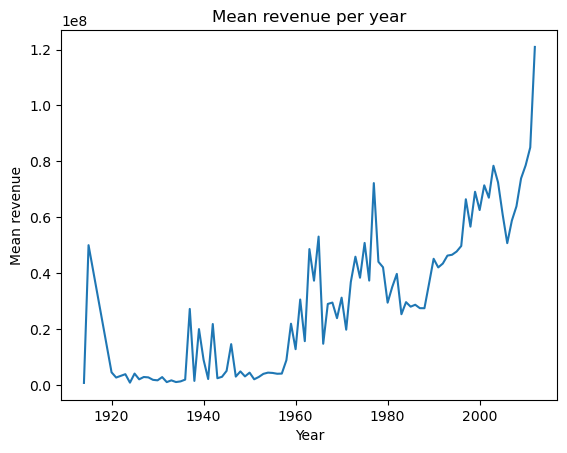

In [12]:

plt.plot(mean_revenue_year)
plt.title("Mean revenue per year")
plt.xlabel("Year")
plt.ylabel("Mean revenue")
plt.show()


### Add rotten tomatoes critic score

In [60]:
def processing_rotten_tomatoes_score():
    rotten_movies = pd.read_csv('data/rotten_tomatoes_movies.csv', sep=',', header=0)

    rotten_movies.drop('rotten_tomatoes_link', axis=1, inplace=True)
    rotten_movies.drop('movie_info', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_status', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_count', axis=1, inplace=True)
    rotten_movies.drop('audience_status', axis=1, inplace=True)
    rotten_movies.drop('audience_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_top_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_fresh_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_rotten_critics_count', axis=1, inplace=True)
    # rotten_movies.drop('original_release_date', axis=1, inplace=True)
    rotten_movies.drop('streaming_release_date', axis=1, inplace=True)
    rotten_movies.drop('runtime', axis=1, inplace=True)
    rotten_movies.drop('genres', axis=1, inplace=True)
    rotten_movies.drop('content_rating', axis=1, inplace=True)
    rotten_movies.drop('actors', axis=1, inplace=True)

    rotten_movies.dropna(subset=['movie_title', 'audience_rating', 'tomatometer_rating'], inplace=True)
    return rotten_movies

rotten_movies = processing_rotten_tomatoes_score()
joined_movies = movies.join(rotten_movies.set_index('movie_title'), on='Movie name', how='inner')


# 8k film to only 6k
# The are error on the merge => the sorcerer's apprentice is not the same movie
# Need to fixed, maybe using the release date

In [64]:
movies = joined_movies

## Analysis

In [65]:
movies.head()

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,critics_consensus,directors,authors,original_release_date,production_company,tomatometer_rating,audience_rating
6,18998739,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,{English Language},{South Africa},"{Fantasy, Adventure, World cinema, Family Film}",It has a likable cast and loads of CGI spectac...,"Jon Turtletaub, Jon Turteltaub","Lawrence Konner, Mark Rosenthal, Doug Miro, Ma...",2010-07-14,Walt Disney Studios,40.0,53.0
18151,18997933,The Sorcerer's Apprentice,1955-01-01,NaN,13.0,{English Language},"{United States of America, West Germany}",{Short Film},It has a likable cast and loads of CGI spectac...,"Jon Turtletaub, Jon Turteltaub","Lawrence Konner, Mark Rosenthal, Doug Miro, Ma...",2010-07-14,Walt Disney Studios,40.0,53.0
49733,12621957,The Sorcerer's Apprentice,2010-07-08,215283742.0,111.0,{English Language},{United States of America},"{Fantasy, Action, Comedy, Adventure, Science F...",It has a likable cast and loads of CGI spectac...,"Jon Turtletaub, Jon Turteltaub","Lawrence Konner, Mark Rosenthal, Doug Miro, Ma...",2010-07-14,Walt Disney Studios,40.0,53.0
7,10408933,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,{English Language},{United States of America},"{Musical, Comedy, Black-and-white}",NaN,Henry King,"Lamar Trotti, Kathryn Scola, Irving Berlin, Ri...",1938-08-16,20th Century Fox Film Corporation,80.0,46.0
13,171005,Henry V,1989-11-08,10161099.0,137.0,{English Language},{United Kingdom},"{Costume drama, War film, Film adaptation, Epi...",Pehaps Kenneth Branagh's most fully realized S...,Kenneth Branagh,Kenneth Branagh,1989-11-08,MGM Home Entertainment,100.0,89.0


In [ ]:
characters.head()

,Wikipedia movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor name,Actor age at movie release
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0
